# Gradient Analysis Part module


In [ ]:
import numpy as np
import os.path as op
import os
import pandas as pd

import matplotlib.pyplot as plt
import pingouin

bids_folder = '/mnt_03/ds-dnumrisk' 
phenotype_folder = op.join(bids_folder, 'derivatives/phenotype')


df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group','age']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

from numrisk.fmri_analysis.gradients.utils_02 import get_all_behavior
df_behav = get_all_behavior(bids_folder).join(group_list['age'], on='subject')

In [84]:
# Between Network Dispersion 
n_grad = 1
fn = f'betweenNdispersion_grad-{n_grad}.csv' #f'withinNdispersion_grad-{n_grad}.csv')).set_index('subject')
df_bn = pd.read_csv(op.join(phenotype_folder,fn)).set_index('subject')
net_name = 'Visual1 - Cingulo-Opercular' # 'Visual2 - Dorsal-attention'# 

fn = 'withinNdispersion-NPC_grad-2.csv'
df_wn_npc = pd.read_csv(op.join(phenotype_folder,fn)).set_index('subject')

df_neuro = df_wn_npc.join(df_bn[net_name])

In [85]:
df_comb = df_neuro.join(df_behav)
df_comb.head()

,,group,NPC_dispersion,NPC_centroid,Visual1 - Cingulo-Opercular,gamma,intercept,n1_slope,weber_frac,Percent Correct,weber_frac_log,...,basisscore,overall_score,erfassungsspanne,memory_noise_sd_unbiased,perceptual_noise_sd_unbiased,skill_score,visio-spatial IQ,verbal IQ,mean_iq,age
subject,group,,,,,,,,,,,,,,,,,,,,,
1,0,0,7.300665,3.686937,2.652029,4.705314,-0.201185,0.025097,0.143232,85.984848,-1.943288,...,5,13.0,8,0.115213,0.102558,36.0,120.0,105.0,112.5,19.0
2,1,1,4.660234,0.477991,6.844300,3.425356,0.046009,0.048086,0.119873,88.257576,-2.121318,...,5,10.0,6,0.196658,0.122329,6.0,100.0,95.0,97.5,17.0
3,0,0,2.410949,1.781235,3.565347,2.933502,-0.153413,0.032216,0.349204,72.348485,-1.052099,...,4,7.0,5,0.213540,0.150741,29.0,115.0,95.0,105.0,15.0
4,1,1,10.872834,2.264704,5.622803,4.930412,-0.136875,0.037974,0.183717,82.196970,-1.694361,...,4,7.0,6,0.105920,0.091129,34.0,110.0,105.0,107.5,17.0
5,0,0,4.050231,0.535087,4.826589,3.599923,-0.279398,0.022015,0.154192,84.469697,-1.869560,...,4,10.0,7,0.127888,0.153583,30.0,90.0,115.0,102.5,20.0


In [90]:
behav_vars = ['skill_score','memory_noise_sd','perceptual_noise_sd','gamma','erfassungsspanne','visio-spatial IQ','weber_frac']
neural_vars = ['NPC_dispersion', net_name]

ind_var = 'neuralVar'
dep_var =   'behaveVar' 
formula = f'{dep_var} ~ {ind_var} + group'


index = pd.MultiIndex.from_product([neural_vars, behav_vars, ['Intercept', ind_var, 'group']], 
                                   names=['NeuralVar', 'BehavVar', 'param'])
model_fits_df = pd.DataFrame(index=index, columns=['p_val', 'coef'])

# Populate the DataFrame
for y_var in neural_vars:
    for x_var in behav_vars:
        df_comb['neuralVar'] = np.log(df_comb[y_var])
        df_comb['behaveVar'] = np.log(df_comb[x_var])
        result = sm.formula.ols(formula=formula, data=df_comb).fit()

        for param in ['Intercept', ind_var, 'group']: # 
            model_fits_df.loc[(y_var, x_var, param), 'p_val'] = result.pvalues.get(param, np.nan)
            model_fits_df.loc[(y_var, x_var, param), 'coef'] = result.params.get(param, np.nan)



In [91]:
print(formula)
model_fits_df

behaveVar ~ neuralVar + group


p_val      coef
NeuralVar                   BehavVar            param                        
NPC_dispersion              skill_score         Intercept       0.0  3.513623
                                                neuralVar  0.760824 -0.034544
                                                group      0.000002 -0.722174
                            memory_noise_sd     Intercept       0.0 -2.015068
                                                neuralVar  0.565384 -0.009416
                                                group           0.0  0.446952
                            perceptual_noise_sd Intercept       0.0  -2.44872
                                                neuralVar  0.756549  0.036663
                                                group           0.0 -0.881028
                            gamma               Intercept       0.0   1.48391
                                                neuralVar  0.465709 -0.045667
                                                group      0.476417 -0.053852
                            erfassungsspanne    Intercept       0.0  1.973586
                                                neuralVar  0.630553  0.016058
                                                group      0.000122 -0.164397
                            visio-spatial IQ    Intercept       0.0  4.630928
                                                neuralVar  0.813365 -0.007844
                                                group      0.042481 -0.082773
                            weber_frac          Intercept       0.0 -1.804432
                                                neuralVar  0.633043  0.035527
                                                group      0.254492  0.102881
Visual1 - Cingulo-Opercular skill_score         Intercept       0.0  4.477229
                                                neuralVar  0.005072 -0.642547
                                                group      0.000003 -0.636875
                            memory_noise_sd     Intercept       0.0 -2.092131
                                                neuralVar  0.251303  0.038997
                                                group           0.0  0.436635
                            perceptual_noise_sd Intercept       0.0 -3.300299
                                                neuralVar  0.017215  0.574087
                                                group           0.0  -0.95465
                            gamma               Intercept       0.0   1.95656
                                                neuralVar  0.006674 -0.344392
                                                group       0.76968 -0.020256
                            erfassungsspanne    Intercept       0.0  1.910191
                                                neuralVar   0.41758  0.056298
                                                group      0.000063 -0.166052
                            visio-spatial IQ    Intercept       0.0  4.624914
                                                neuralVar  0.951754 -0.004189
                                                group      0.030569 -0.085618
                            weber_frac          Intercept       0.0 -1.971207
                                                neuralVar  0.361025   0.14127
                                                group       0.26647  0.096597

In [82]:
model_fits_df.to_csv(op.join(phenotype_folder, f'grad-behav_regresssion-model_fits_df_indVar-{ind_var}.csv'))

<Axes: >

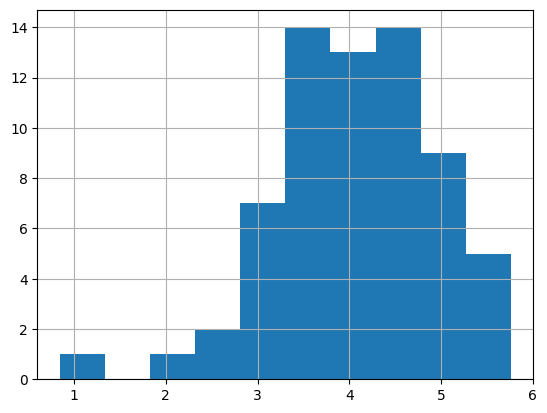

In [92]:
df_behav['gamma'].hist()